# Tutorial 43: Risk Parity with a Risk Constraint per Classes

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4035%,1.9692%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9759%,0.6987%,1.7539%,-0.1729%,0.2410%,1.3735%,-1.0857%
2016-01-06,-11.4864%,-1.5879%,0.2411%,-1.7556%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5647%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1046%,-1.9770%,-1.2206%,-0.8856%,-4.6058%,-2.5394%,...,-2.2066%,-3.0309%,-1.0410%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5493%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1098%,-0.2240%,0.5706%,-1.6402%,-1.7642%,-0.1649%,...,-0.1539%,-1.1366%,-0.7308%,-0.1448%,0.0895%,-3.3839%,-0.1117%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3383%,0.1693%,-1.6851%,-1.0215%,0.0915%,-1.1791%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5800%,-1.9919%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,6.1590%,11.5019%,0.0000%,0.0000%,8.4806%,0.0000%,3.8194%,0.0000%,0.0000%,...,10.8263%,0.0000%,0.0000%,0.0000%,0.0000%,7.1804%,0.0000%,0.0000%,4.2741%,0.0000%


### 2.2 Plotting portfolio composition

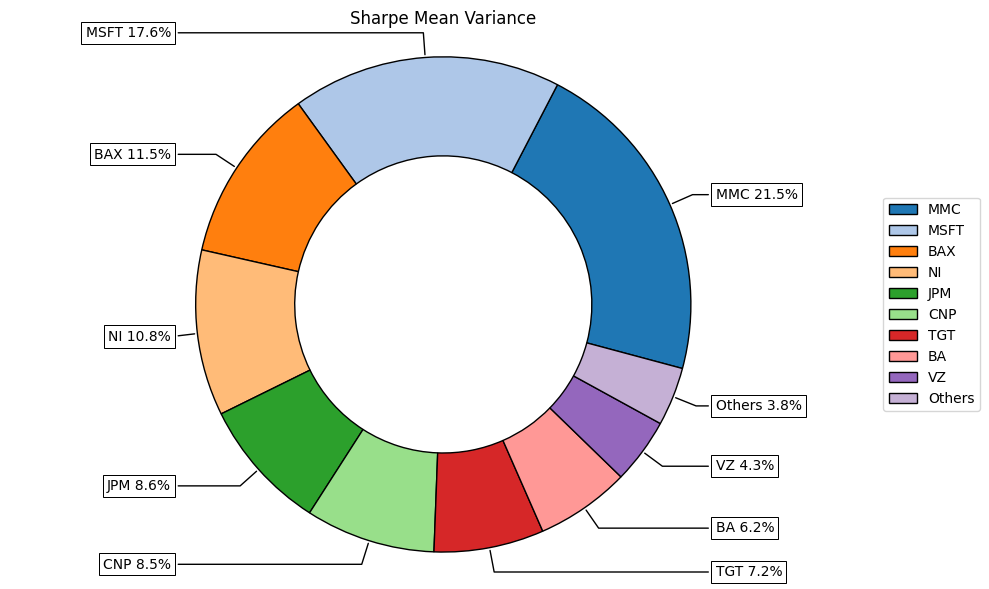

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting Risk Composition

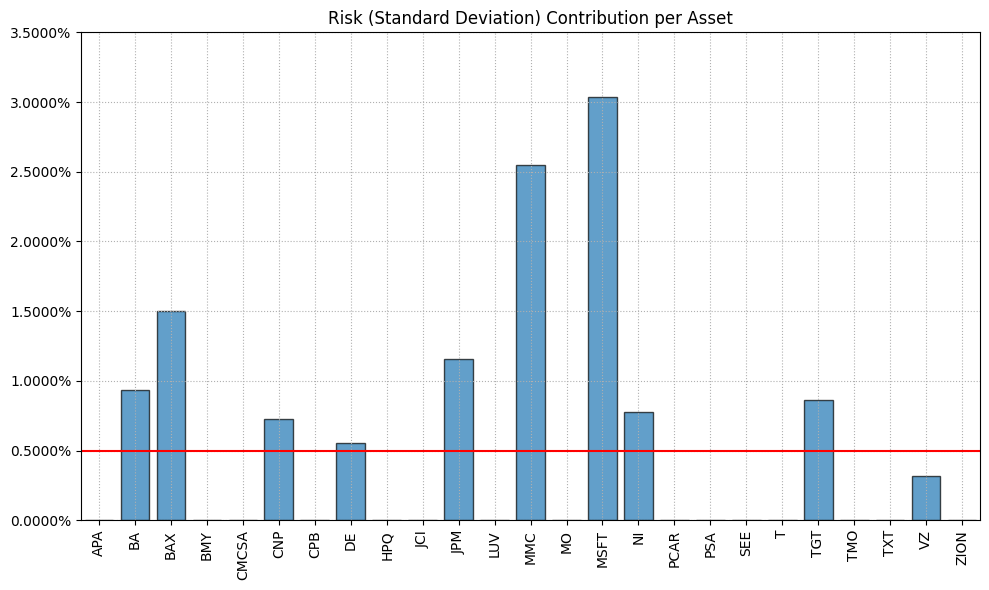

In [5]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for Other Risk Measures

이번 부분에서는 리스크 패리티 포트폴리오를 계산할 것입니다. 먼저, 분산을 리스크 측정치로 사용할 때 리스크 패리티 포트폴리오를 계산한 후, 사용 가능한 모든 리스크 측정치에 대해 리스크 패리티 포트폴리오를 계산할 것입니다.

### 3.1 Calculating the risk parity portfolio for variance.

In [9]:
asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
                            'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
                            'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health Care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
asset_classes.reset_index(inplace=True, drop=True)

display(asset_classes)

# Risk contribution constraints vector based on Industry Class
b = rp.risk_constraint(asset_classes,
                       kind='classes',
                       classes_col='Industry')

print(b)

,Assets,Industry
0,APA,Energy
1,BA,Financials
2,BAX,Health Care
3,BMY,Health Care
4,CMCSA,Consumer Discretionary
5,CNP,Utilities
6,CPB,Consumer Staples
7,DE,Industrials
8,HPQ,Information Technology
9,JCI,Consumer Discretionary


[[0.1       ]
 [0.02      ]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.05      ]
 [0.05      ]
 [0.025     ]
 [0.05      ]
 [0.03333333]
 [0.02      ]
 [0.025     ]
 [0.02      ]
 [0.05      ]
 [0.05      ]
 [0.05      ]
 [0.025     ]
 [0.02      ]
 [0.1       ]
 [0.05      ]
 [0.03333333]
 [0.03333333]
 [0.025     ]
 [0.05      ]
 [0.02      ]]


In [10]:
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,5.3439%,1.7033%,3.5236%,3.6758%,3.3979%,6.2252%,6.1021%,2.0534%,3.6205%,3.2077%,...,7.7726%,2.0015%,3.8378%,8.2112%,5.6698%,3.5597%,3.0270%,1.9997%,6.3238%,1.6576%


### 3.2 Plotting portfolio composition

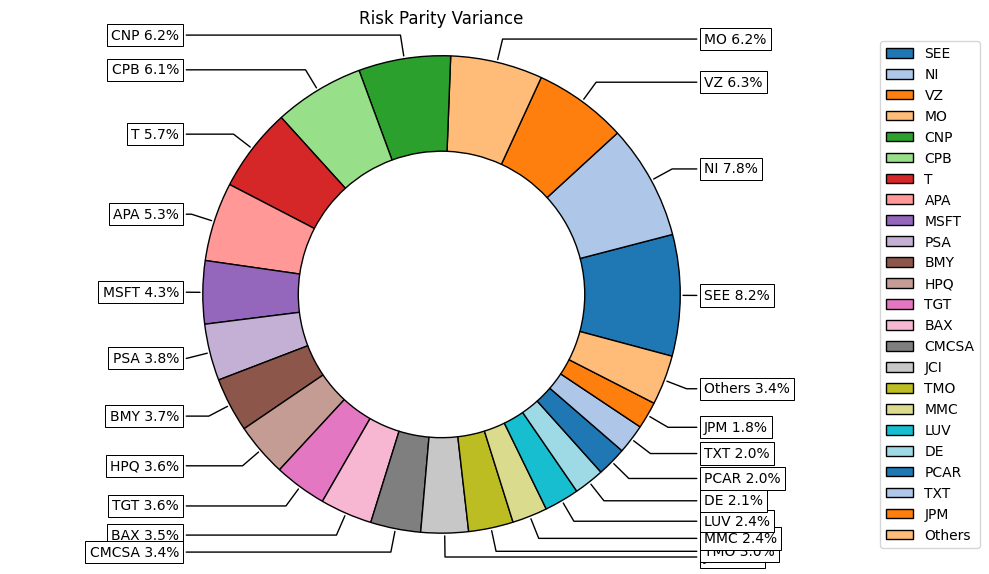

In [11]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Plotting Risk Composition

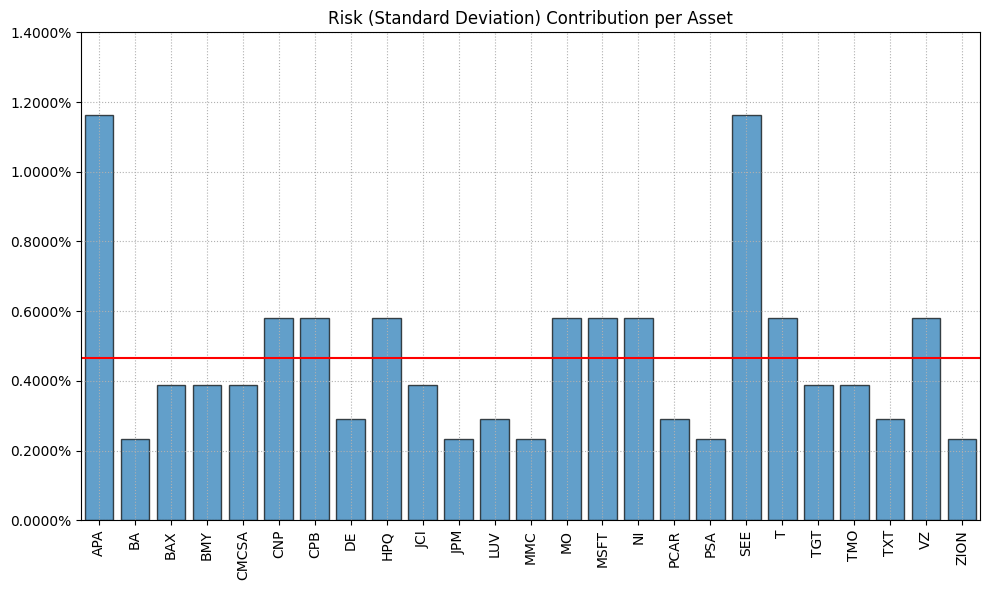

In [12]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures

In [13]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'CVaR', 'CDaR', 'UCI']

w_s = pd.DataFrame([])
port.solvers = ['MOSEK']

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b=b, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [14]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,CDaR,UCI
APA,5.34%,4.89%,5.68%,4.48%,5.49%,5.55%,3.08%,3.00%
BA,1.70%,1.82%,1.64%,1.96%,1.68%,1.54%,4.33%,5.01%
BAX,3.52%,3.91%,3.46%,4.15%,3.56%,3.33%,2.40%,3.07%
BMY,3.68%,3.94%,3.75%,3.71%,3.65%,3.80%,1.92%,1.47%
CMCSA,3.40%,3.38%,3.39%,3.57%,3.42%,3.17%,2.29%,2.22%
CNP,6.23%,6.15%,6.24%,6.19%,6.37%,6.92%,9.37%,7.12%
CPB,6.10%,5.37%,6.75%,5.14%,6.69%,7.98%,3.69%,3.08%
DE,2.05%,2.12%,1.94%,2.26%,1.98%,1.80%,3.27%,3.86%
HPQ,3.62%,3.78%,3.40%,3.84%,3.39%,3.08%,3.52%,3.64%
JCI,3.21%,3.18%,3.24%,3.24%,3.23%,3.21%,1.69%,1.82%


<Axes: >

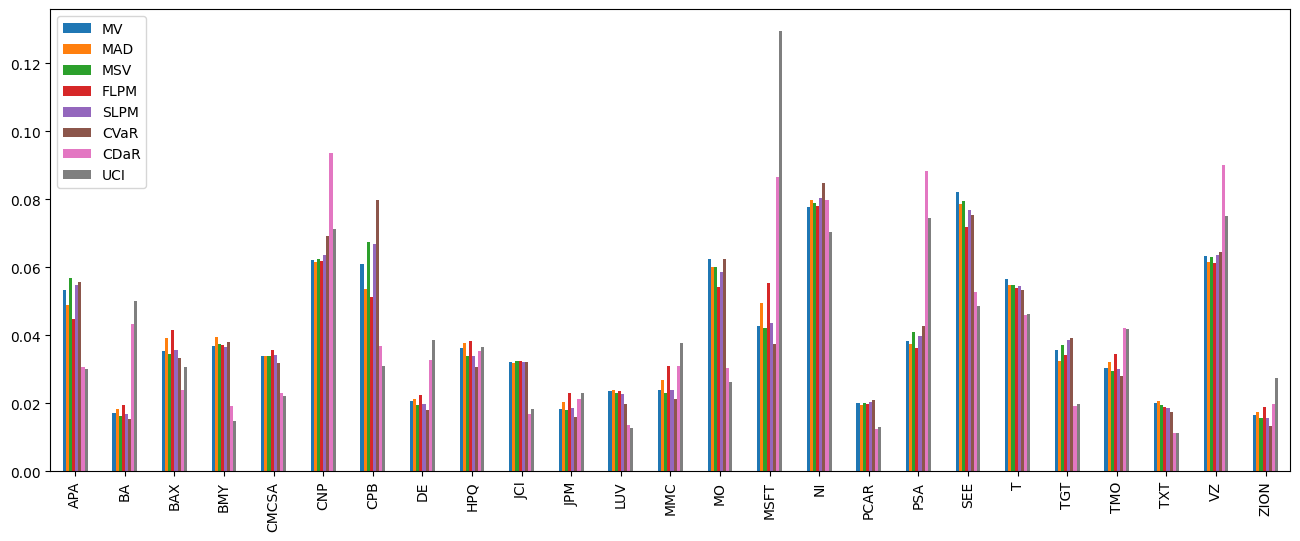

In [15]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)